## Detecting Clickbait Headlines in Indonesia

In this notebook, we will try to predict whether a headline in Indonesian News is a clickbait or not.

In [6]:
import numpy as np
import pandas as pd

In [7]:
data = pd.read_csv("data_input/clickbait-news.csv")

Let's add a new column called `length`, which is simply the number of words on a text.

In [8]:
data["length"] = [len(text.split()) for text in data.text]
data.head()

,text,label,length
0,Purnomo Serahkan Surat Mundur dari Pilkada ke...,0,10
1,Pemkot Bekasi Teken Aturan Tempat Hiburan Menu...,0,9
2,"New Normal 5 Juni, ASN Tak Mesti Berbondong-bo...",0,10
3,WHO Waspadai Banyak Kematian di Puncak Kedua P...,0,9
4,VIDEO: Trump Ancam Tutup Twitter,1,5


## 1. Exploratory Data Analysis

First let's see the distribution around the data

In [9]:
print(len(data.index))

3237


There are 3237 texts/headlines in this data

In [10]:
data.label.value_counts().plot.bar()

There are less clickbait contents/headlines than non-clickbait one, but it's closer to balance.

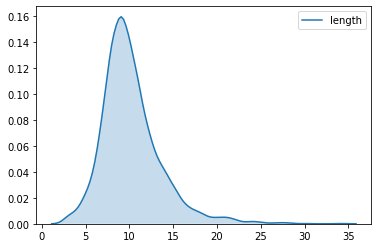

In [11]:
import seaborn as sns
sns.kdeplot(data.sort_values(by="length", ascending=False).length, shade=True)

The length of the headlines has a normal distribution.

## 2. Text Pre-processing

Before building our NLP model, we have to clean the text first through some steps.

1. Lower-casing
2. Remove numbers and punctuations
3. Remove stopwords
4. Tokenizing

In [12]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
stopwords_id = pd.read_csv("data_input/stopwords.txt", header=None)
stopwords_id.columns = ["Words"]

In [14]:
def preprocess(data):
    token = word_tokenize(data)
    token = [text.lower() for text in token]
    token = [text for text in token if text.isalpha()]
    token = [text for text in token if not stopwords_id.Words.eq(text).any()]
    return token

In [15]:
def clean_text(data):
    token = preprocess(data)
    words = token[0]
    for num in range(1,len(token)):
        words = words + (" " + token[num])
    return words

In [16]:
data["text_clean"] = [clean_text(text) for text in data.text]

In [17]:
count_vec = CountVectorizer(ngram_range=(1,2), min_df = 2)
token = count_vec.fit_transform(data.text_clean)

In [18]:
token

<3237x4599 sparse matrix of type '<class 'numpy.int64'>'
	with 22881 stored elements in Compressed Sparse Row format>

There are 4599 terms which appear at least in 2 documents, and these terms could be a single word or two words (bigram).

## 3. Most Frequent Terms

After tokenizing the text, we can now see which terms appear the most.

In [19]:
def most_freq_terms(min_len, max_len):
    most_freq_vec = CountVectorizer(ngram_range=(min_len,max_len))
    most_freq_mat = most_freq_vec.fit_transform(data.text_clean)
    terms = most_freq_vec.get_feature_names()
    freq = most_freq_mat.toarray().sum(axis=0)
    df = pd.DataFrame(freq, terms)
    df.columns = ["Terms"]
    df = df.sort_values(by = "Terms", ascending = False)
    df.head(10).plot.bar()

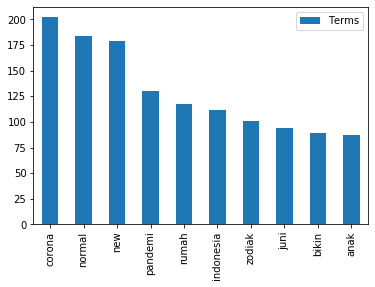

In [20]:
most_freq_terms(1,1)

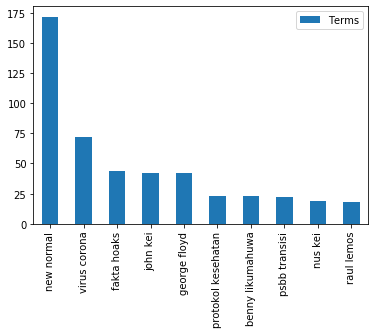

In [21]:
most_freq_terms(2,2)

Terms like **new normal**, **virus corona**, and **pandemi** appear a lot since the data was scraped from the last few months.

## 4. Modelling : Naive-Bayes

We can now fit the data into the model. First we will try a simple model aka Naive-Bayes.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [23]:
train_x, test_x, train_y, test_y = train_test_split(token, data.label, test_size = 0.2, random_state = 42)

In [24]:
print("Train Size :", train_x.shape)
print("Test Size :", test_x.shape)

Train Size : (2589, 4599)
Test Size : (648, 4599)


In [25]:
nb = MultinomialNB()
nb.fit(train_x, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
nb.score(train_x, train_y)

0.8760139049826188

In [27]:
nb.score(test_x, test_y)

0.7175925925925926

87.6% Accuracy for train dataset and only 71,7% for test dataset. Not really a good performance.

## 5. Modelling : Neural Networks

In most cases, for NLP, you'd prefer to use neural networks rather than models like Naive-Bayes simply because it is a much better algorithm. First we have to do pad sequencing, which is a step of giving index to each words (sequencing), and then normalizing the text length by using padding method.

In [28]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

Using TensorFlow backend.
C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [29]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.label, test_size = 0.2, random_state = 42)

In [30]:
VOCAB_SIZE = 2000
MAX_LEN = 50
tkz = Tokenizer(num_words=VOCAB_SIZE)
tkz.fit_on_texts(x_train)
sequences = tkz.texts_to_sequences(x_train)
sequences = sequence.pad_sequences(sequences, maxlen=MAX_LEN)

Here we set the vocabulary size to 2000 and maximum sequence/length for each text to be 50 words.

Then we can simply fit our RNN model

In [31]:
from tensorflow.random import set_random_seed

In [32]:
np.random.seed(42)
set_random_seed(42)
model = Sequential()
model.add(Embedding(VOCAB_SIZE, 50, input_length = MAX_LEN))
model.add(LSTM(64))
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 146,337
Trainable params: 146,337
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [35]:
model.fit(sequences, y_train, batch_size=128, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2589/2589 [==============================] - 1s 546us/step - loss: 0.6690 - accuracy: 0.5917
Epoch 2/10
2589/2589 [==============================] - 1s 404us/step - loss: 0.5466 - accuracy: 0.7570
Epoch 3/10
2589/2589 [==============================] - 1s 425us/step - loss: 0.3929 - accuracy: 0.8324
Epoch 4/10
2589/2589 [==============================] - 1s 416us/step - loss: 0.3026 - accuracy: 0.8779
Epoch 5/10
2589/2589 [==============================] - 1s 411us/step - loss: 0.2545 - accuracy: 0.8992
Epoch 6/10
2589/2589 [==============================] - 1s 410us/step - loss: 0.2142 - accuracy: 0.9197
Epoch 7/10
2589/2589 [==============================] - 1s 405us/step - loss: 0.1816 - accuracy: 0.9351
Epoch 8/10
2589/2589 [==============================] - 1s 411us/step - loss: 0.1597 - accuracy: 0.9424
Epoch 9/10
2589/2589 [==============================] - 1s 439us/step - loss: 0.1368 - accuracy: 0.9537
Epoch 10/10
2589

In [36]:
sequences_test = tkz.texts_to_sequences(x_test)
sequences_test = sequence.pad_sequences(sequences_test, maxlen=MAX_LEN)

In [37]:
model.evaluate(sequences_test, y_test)

648/648 [==============================] - 0s 313us/step


[0.8720438178674674, 0.7175925970077515]

Even a simple LSTM model (3 layers and 10 epochs) has already done well. With a small data like this, 76% is a decent accuracy. Surely we can still improve this model by adding more layers, using different batch size, do more epochs, etc.

## 6. Summary

1. There are a lot of clickbait headlines in Indonesia
2. The last few months, the most occuring terms in Indonesian headlines are virus corona, new normal, and pandemi
3. We can predict a headline is clickbait or not with a 76% accuracy.

In [38]:
pd.to_pickle(model, "data_input/model")
pd.to_pickle(tkz, "data_input/token")